# Tutorial 4: Applying Dynamic Forcing Functions to GRN Nodes in Boolean Models
When working with NFSMs, the signals applied to the "input nodes" of the GRN are typically 
not changing until the system reaches an equilibrium. Here we show how to use Cellnition to 
run a pseudo-temporal simulation where an input node is stimulated by a square-wave signal, and how to visualize the output.  

In this tutorial, we create a Boolean based model of the larger MAPK network and 
show how to run the pseudo-time simulation on this larger model case. 

In [1]:
import os
import csv
import copy
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
from matplotlib import colormaps
import networkx as nx

from scipy.sparse import lil_array

from cellnition.science.network_models.network_enums import (EdgeType, 
                                                             GraphType, 
                                                             NodeType, 
                                                             InterFuncType, 
                                                             CouplingType, 
                                                             EquilibriumType
                                                            )
# from cellnition.science.network_workflow import NetworkWorkflow
from cellnition.science.networks_toolbox.netplot import plot_network

from cellnition.science.network_models.network_library import MAPK_net

from cellnition.science.network_models.boolean_networks import BooleanNet
from cellnition.science.networks_toolbox.boolean_state_machine import BoolStateMachine

In [2]:
# Save path for images and graphs:
save_path_base = '/home/pietakio/Documents/CellnitionSims/Boolean' # YOUR CUSTOM ROOT DIRECTORY HERE! 
save_path_oo = os.path.join(save_path_base, 'May1_2025')
if not os.path.isdir(save_path_oo):
    os.makedirs(save_path_oo)

In [3]:
# load the network base from the Cellnition library:
libg = MAPK_net()

# Specify how to combine multiple nodes interacting together:
multi_coupling_type = CouplingType.mix1 # activators combine as "OR" and inhibitors "AND"
# multi_coupling_type = CouplingType.additive # everything "OR"
# multi_coupling_type = CouplingType.multiplicative # everything "AND"
# multi_coupling_type = CouplingType.mix2  # activators combine "AND" and inhibitors "OR"

constitutive_express = False # activators present "AND" inhibitors absent for expression, when "False"

# NOTE: Mix1 is the default combinatory strategy. CouplingType.mix1 combines multiple activators in an "OR" fashion (additive) and 
# multiple inhibitors in an "AND" fashion (multiplicative). This combinatory strategy specifies that individual activators have 
# equal influence on the downstream gene activation, whereas all inhibitors must be absent for gene activaton and the pressense of
# a single inhibitor can cease all downstream gene expression of the downstream node. 

# Furthermore, in the Boolean model, constitutive_express = False combines the set of all activators and the set of all inhibitors 
# in a multiplicative "AND" fashion, which states: the effect of activators must
# be present AND all inhibitors must be absent for gene expression at the downstream node. This has the exception that if a node only has
# inhibitors acting on it, it is assumed to have constitutive expression, such that only the absense of the inhibitors is required for 
# expression. These conventions are considered the standard heuristic in Boolean network models (see Schwab et al. - 2020).

In [4]:
bnet = BooleanNet() # Instantiate the Boolean GRN network solver
bnet.build_network_from_edges(libg.edges) # Build the basic graph/network from the imported MAPK_net library network 
bnet.characterize_graph() # Characterize the graph and set key parameters
bnet.set_node_types() # Set the node types to a default value

bnet.set_edge_types(libg.edge_types) # set the edge types to those defined in the MAPK_net network

In [5]:
# Use the above-specified options to define a final sub-directory for the results:
save_path_o = os.path.join(save_path_oo, f'_{multi_coupling_type.name[0:4]}')
if not os.path.isdir(save_path_o):
    os.makedirs(save_path_o)

# Final save directory is for the individual network that is being studied: 
save_path = os.path.join(save_path_o, f'{libg.name}' )
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Set some easily-modifiable text parameters for plots: 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fimg = '.png' # Format for exported graph images. Can use '.png' for bitmap or '.svg' for vector graphics. 

In [6]:
# save plots of the GRN graph:
# Shared parameters used on the following graph images:
arrowsize = 2.0 # Size of the directed head of the graph edges (relative units) 
node_font_size = 24 # Size of the font used on node labels
net_font_name =  'DejaVu Sans Bold' # name of font used on node labels
edge_width = 2.0 # with of interaction edges
nde_outline = 'Black' # colour of the node outline (if no outline is desired use "None")
rev_font_color = False # Reverse the color of node text? It is black by default. 
label_edges=False # Label the edges with their index in the BooleanNet object (bnet)? 

# NOTE: label_edges=True is useful in inspection and validation of equations, as the 
# edge index is also the index of 'n_base' and 'bb' params, above (the 'dd' param is labeled to node index). 

# The network shown in a hierarchical layout with node color representing the "hierarchical level" of the node
# as calculated in 'characterize_graph' and described in Moutsinas et. al - 2021: 
graph_net_hier = f'hier_graph_{libg.name}{fimg}' 
save_graph_net_hier = os.path.join(save_path, graph_net_hier)

gp=plot_network(bnet.nodes_list,
                bnet.edges_list,
                bnet.node_types,
                bnet.edge_types,
                node_vals = bnet.hier_node_level, # color the nodes to their hierarchical level
                val_cmap = 'viridis_r',
                save_path=save_graph_net_hier,
                layout='dot',
                rev_font_color=rev_font_color,
                label_edges=label_edges,
                net_font_name=net_font_name,
                node_font_size=node_font_size,
                edge_width=edge_width,
                nde_outline=nde_outline,
                arrowsize=arrowsize
                )

# The network shown in a circular layout with nodes colored acording to whether they are present in cycles or not:
graph_net_circ = f'circ_graph_{libg.name}{fimg}'
save_graph_net_circo = os.path.join(save_path, graph_net_circ)   

cycle_tags = np.zeros(bnet.N_nodes)
cycle_tags[bnet.nodes_in_cycles] = 1.0

gp=plot_network(bnet.nodes_list,
                bnet.edges_list,
                bnet.node_types,
                bnet.edge_types,
                node_vals = cycle_tags,
                val_cmap = 'Blues',
                save_path=save_graph_net_circo,
                layout='circo',
                rev_font_color=rev_font_color,
                label_edges=label_edges,
                net_font_name=net_font_name,
                node_font_size=node_font_size,
                edge_width=edge_width,
                nde_outline=nde_outline,
                arrowsize=arrowsize
                )

In [7]:
# Use the network/graph characteristics to build a Boolean network solver for the GRN:
c_vect_s, A_bool_s, A_bool_f = bnet.build_boolean_model(use_node_name=True,
                                                      multi_coupling_type=multi_coupling_type,
                                                     constitutive_express=constitutive_express)

In [8]:
# Inspect the gene variables list:
c_vect_s

Matrix([
[           AKT],
[           AP1],
[          ATF2],
[           ATM],
[     Apoptosis],
[          BCL2],
[          CREB],
[    DNA_damage],
[         DUSP1],
[          EGFR],
[ EGFR_stimulus],
[          ELK1],
[           ERK],
[         FGFR3],
[FGFR3_stimulus],
[           FOS],
[         FOXO3],
[          FRS2],
[          GAB1],
[        GADD45],
[          GRB2],
[ Growth_Arrest],
[           JNK],
[           JUN],
[      MAP3K1_3],
[           MAX],
[          MDM2],
[        MEK1_2],
[           MSK],
[          MTK1],
[           MYC],
[          PDK1],
[          PI3K],
[           PKC],
[          PLCG],
[        PPP2CA],
[          PTEN],
[ Proliferation],
[           RAF],
[           RAS],
[           RSK],
[          SMAD],
[           SOS],
[          SPRY],
[          TAK1],
[          TAOK],
[         TGFBR],
[TGFBR_stimulus],
[           p14],
[           p21],
[           p38],
[           p53],
[           p70]])

In [9]:
# Inspect the generative equations for this Boolean model:
A_bool_s

Matrix([
[                                    PDK1*(1 - PTEN)],
[                             ATF2/3 + FOS/3 + JUN/3],
[                                      JNK/2 + p38/2],
[                                         DNA_damage],
[             (1 - BCL2)*(1 - ERK)*(FOXO3/2 + p53/2)],
[                                     AKT/2 + CREB/2],
[                                                MSK],
[                                                  0],
[                                               CREB],
[    (1 - GRB2)*(1 - PKC)*(EGFR_stimulus/2 + SPRY/2)],
[                                                  0],
[                              ERK/3 + JNK/3 + p38/3],
[                                             MEK1_2],
[                FGFR3_stimulus*(1 - GRB2)*(1 - PKC)],
[                                                  0],
[                    CREB/4 + ELK1/4 + ERK/4 + RSK/4],
[                                      JNK*(1 - AKT)],
[                        FGFR3*(1 - GRB2)*(1 - SPRY)],
[

## Dynamically stimulate input nodes using pseudo-time stepping sequences   
Here we show how to dynamically stimulate input nodes with a custom sequence in a pseudo-time-based simulations (sequence simulations on the Boolean model). 

In [10]:
tend = 150 # Iteration (time unit) at which the pseudo-time simulation should end.

# Get the full time vector (tvect) and the sampled time vector (tvectr)
tvect = np.arange(tend, dtype=int)

# this is a starting state for expression levels of nodes in the network:
cvecti = np.zeros(bnet.N_nodes, dtype=int)

# Creating a dynamic stimulation to be applied to the GRN's input nodes:
sig_inds = bnet.input_node_inds # These are the nodes that are to be stimulated (short alias)
N_sigs = len(sig_inds) # The length of nodes that will be stimulated

# Set a baseline value for the minima of any of the stimulation node levels. Note that concentrations
# cannot go below zero. Here we set the minima to 0.0:
sig_base_vals = [0 for i in bnet.input_node_inds] 

# Create the stimulation signals, lets use a clipped sinusoidal function on the first input node index:
freq = 1.0/30.0 # let's have the cycle repeat every 30 time units
stim_i = 1 # index of the input node that we'll apply the sinusoid to (note this is not the 
# absolute node index in the GRN but the index wrt pnet.input_node_inds array). 
sine_stim = np.round((1/2)*(np.sin(2*np.pi*freq*tvect) + 1.0)) # clipped to be a Boolean 0, 1 signal

# Initialize a numpy array with all zeros in it; it needs to be the size of all nodes in the GRN:
stim_sigs = np.zeros((len(tvect), len(sig_inds))) # create an array to hold dynamic vals of stim signals
stim_sigs[:, stim_i] = sine_stim 

# Calculate the output of the GRN under this dynamic, square-wave stimulation:
ctime = bnet.run_iter_sim(tvect, # main time vector
                          cvecti, # initial state of the network nodes
                          A_bool_f, 
                          sig_inds, # indices of the input inds (must be pnet.input_node_inds)
                          stim_sigs, # the ndarray with the stimulation signal in it
                         )

# The ctime array has the time-sampled expression level of all nodes in the network as a function 
# of sampled time step, which is specfied in tvectr. 

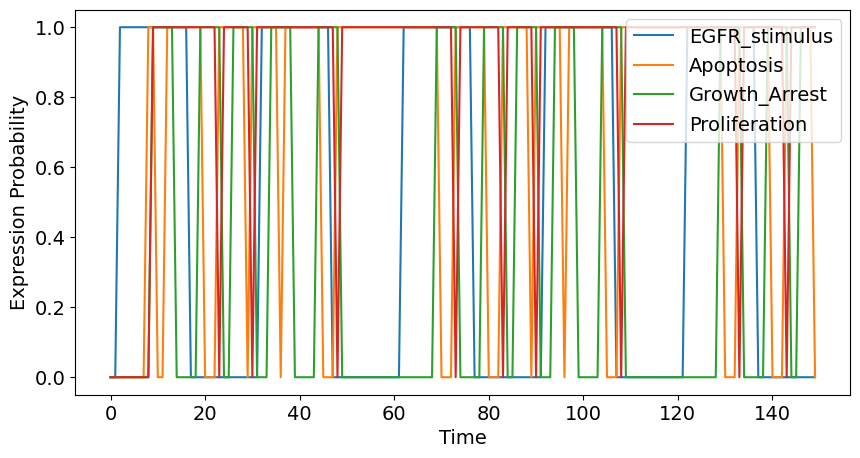

In [12]:
# Plot the results of the pseudo-time simulation with respect to the output node levels: 
# Plot things up to see what we have -- here picking output nodes to plot: 
plt.figure(figsize=(10,5))
plt.plot(tvect, ctime[:, sig_inds[stim_i]], label=bnet.nodes_list[sig_inds[stim_i]]) # Stimulated node (EGFR)
plt.plot(tvect, ctime[:, 0], label=bnet.nodes_list[4]) # Apoptosis
plt.plot(tvect, ctime[:, 1], label=bnet.nodes_list[21]) # Growth Arrest
plt.plot(tvect, ctime[:, 5], label=bnet.nodes_list[37]) # Proliferation
plt.xlabel("Time")
plt.ylabel("Expression Probability")

plt.legend(frameon=True, loc='upper right')
plt.show()